In [5]:
from my_mnist_loader import *

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = my_load_data_wrapper()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 784)
Train labels shape:  (50000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __getitem__(self, index):
        f = torch.tensor(self.features[index])
        l = torch.tensor(self.labels[index])
        return (f.to(device), l.to(device))

    def __len__(self):
        return len(self.labels)

In [10]:
# Create data loader
batch_size = 100
train_data = CustomDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_data = CustomDataset(X_val, y_val)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_data = CustomDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [37]:
def evaluate(model, dataset, max_ex=0):
    model.eval()
    acc = 0
    # len(dataset) 是 batch 的个数
    for i, (features, labels) in enumerate(dataset):
        scores = model(features)
        # scores 是 100x10 的矩阵，10是一个样本的每个类别的归一化前的值
        pred = torch.argmax(scores, dim=1)
        # pred 是 100x1 的矩阵，全是类别的数字，和 labels 一样
        # torch.eq 返回 true 或 false，sum 会把 true 的个数加起来
        # print(torch.eq(pred, labels))
        acc += torch.sum(torch.eq(pred, labels)).item()
        if max_ex != 0 and i >= max_ex:
            break
    # print(i)
    return (acc * 100 / ((i+1) * batch_size) )

In [34]:
a = torch.Tensor([1,2,3])
b = torch.Tensor([1,2,0])
torch.eq(a,b)
torch.sum(torch.eq(a,b))

tensor(2)

In [14]:
import torch
import torch.nn as nn
from torch.optim import Adam
from models import *
from plot_funcs import *

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda:3")
else:
    device = torch.device("cpu")

In [18]:
# Create our teacher model
big_model = linear_net().to(device)

In [19]:
# Load our pre-trained teacher model
load_path = "teacher_linear_model/"
checkpoint = torch.load(load_path + "modelo")
big_model.load_state_dict(checkpoint['model_state_dict'])
big_model.eval()

linear_net(
  (linear_1): Linear(in_features=784, out_features=1200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_2): Linear(in_features=1200, out_features=1200, bias=True)
  (linear_3): Linear(in_features=1200, out_features=10, bias=True)
)

In [40]:
train_acc = evaluate(big_model, train_loader)
print("\nTrain accuracy: %.2f%%" % train_acc)
val_acc = evaluate(big_model,val_loader)
print("Validation accuracy: %.2f%%" % val_acc)
test_acc = evaluate(big_model, test_loader)
print("Test accuracy: %.2f%%" % test_acc)


Train accuracy: 99.66%
Validation accuracy: 98.18%
Test accuracy: 97.84%


In [29]:
# Create our student model
small_model = small_linear_net().to(device)

In [30]:
# Load our pre-trained student model
# This is just if you want to check the accuracy of this model
# trained with the original MNIST data
load_path = "small_linear_model/"
checkpoint = torch.load(load_path + "modelo")
small_model.load_state_dict(checkpoint['model_state_dict'])
small_model.eval()

small_linear_net(
  (linear_1): Linear(in_features=784, out_features=50, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=50, out_features=10, bias=True)
)

In [38]:
train_acc = evaluate(small_model, train_loader)
print("\nTrain accuracy: %.2f%%" % train_acc)
val_acc = evaluate(small_model,val_loader)
print("Validation accuracy: %.2f%%" % val_acc)
test_acc = evaluate(small_model, test_loader)
print("Test accuracy: %.2f%%" % test_acc)


Train accuracy: 99.27%
Validation accuracy: 96.92%
Test accuracy: 96.71%


In [43]:
### Define our custom loss function
softmax_op = nn.Softmax(dim=1)
mseloss_fn = nn.MSELoss()

# default: T=5
def my_loss(scores, targets, T=5):
    soft_pred = softmax_op(scores / T)
    soft_targets = softmax_op(targets / T)
    loss = mseloss_fn(soft_pred, soft_targets)
    return loss

100%|██████████| 500/500 [00:45<00:00, 10.89it/s]


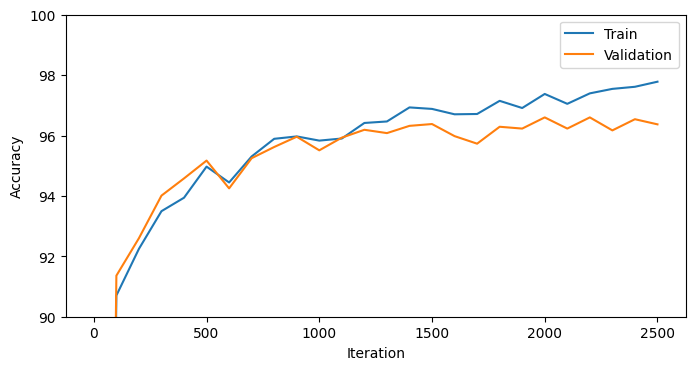

In [52]:
# Create a new student model to start training from zero
small_model = small_linear_net().to(device)
from tqdm import tqdm
%matplotlib inline

# Hyperparameters
lr = 5e-3
epochs = 5
temp = 1
it = 0
# Create optimizer
optimizer = Adam(small_model.parameters(), lr=lr)
val_acc = []
train_acc = []
train_loss = [0]  # loss at iteration 0
for epoch in range(epochs):
    for features, labels in tqdm(train_loader):
        small_model.train()
        scores = small_model(features)
        targets = big_model(features)
        loss = my_loss(scores, targets, T = temp)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Book-keeping
        if it % 100 == 0:
            train_acc.append(evaluate(small_model, train_loader, max_ex=100))
            val_acc.append(evaluate(small_model, val_loader))
        it += 1
#perform last book-keeping
train_acc.append(evaluate(small_model, train_loader, max_ex=100))
val_acc.append(evaluate(small_model, val_loader))
plot_acc(train_acc, val_acc, it, it_per_epoch=0)

In [51]:
print(len(train_acc))
print(len(val_acc))

26
26


In [53]:
train_acc = evaluate(small_model, train_loader)
print("\nTrain accuracy: %.2f%%" % train_acc)
val_acc = evaluate(small_model,val_loader)
print("Validation accuracy: %.2f%%" % val_acc)
test_acc = evaluate(small_model, test_loader)
print("Test accuracy: %.2f%%" % test_acc)


Train accuracy: 97.35%
Validation accuracy: 96.37%
Test accuracy: 96.59%
